In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
from datetime import datetime
import re
import scipy 
from scipy import stats
sns.set_theme(context = 'talk', style = 'darkgrid')

## Join NHL and Elite datasets 

In [2]:
#load files 
nhl_data = pd.read_csv(r'C:\Users\akobe\OneDrive\Desktop\Lighthouse\Final\Predicting_Success_First_Round_Picks_NHL\Data\nhl_data.csv', index_col = [0]) #index col makes sures another index column is not needed
elite_data =  pd.read_csv(r'C:\Users\akobe\lighthouse-data-notes\Final-Data\final_data\all_elite_prospect_data.csv', index_col = [0])

In [3]:
nhl_data.head(2)

draft_year  pick_no                 team  prospect_name  prospect_id  \
0        2009        1   New York Islanders   John Tavares        24111   
1        2009        2  Tampa Bay Lightning  Victor Hedman        33799   

          dob birth_country height  weight shoots   nhl_id position  \
0  1990-09-20           CAN  6' 1"     209      L  8475166        C   
1  1990-12-18           SWE  6' 6"     220      L  8475167        D   

       prospect_category amateur_league amateur_team  nhl_games_played  \
0  North American Skater            OHL       London              1017   
1        European Skater         SWEDEN         Modo               964   

   200+games  
0          1  
1          1

In [4]:
elite_data.head(2)

nhl_id  elite_id     elite_name   elite_dob  draft_year draft_season  \
0  8475166      9223   John Tavares  1990-09-20        2009    2008-2009   
1  8475167      6007  Victor Hedman  1990-12-18        2009    2008-2009   

   prospect_gp  prospect_g  prospect_a  prospect_pts  prospect_pim  \
0           56          58          46           104            54   
1           45           7          16            23            62   

   prospect_pm  
0           10  
1           21

In [5]:
#join the datasets on nhl_id
data = pd.merge(elite_data, nhl_data,  on = 'nhl_id')

In [6]:
data.head(2)

nhl_id  elite_id     elite_name   elite_dob  draft_year_x draft_season  \
0  8475166      9223   John Tavares  1990-09-20          2009    2008-2009   
1  8475167      6007  Victor Hedman  1990-12-18          2009    2008-2009   

   prospect_gp  prospect_g  prospect_a  prospect_pts  ...  birth_country  \
0           56          58          46           104  ...            CAN   
1           45           7          16            23  ...            SWE   

   height  weight  shoots position      prospect_category  amateur_league  \
0   6' 1"     209       L        C  North American Skater             OHL   
1   6' 6"     220       L        D        European Skater          SWEDEN   

  amateur_team nhl_games_played 200+games  
0       London             1017         1  
1         Modo              964         1  

[2 rows x 28 columns]

In [7]:
#drop unwanted columns and columns that are duplicates of each other 
data = data.drop(['draft_year_y', 'prospect_name', 'prospect_id', 'dob'], axis=1)

In [8]:
#rename columns 
data.rename(columns = {'draft_year_x':'draft_year', 'elite_name': 'name', 'elite_dob': 'dob'}, inplace = True)

In [9]:
#convert dob to date, extract out the year, month, day 
data['dob'] = pd.to_datetime(data['dob'])
data['birth_year']= data['dob'].dt.year
data['birth_month']= data['dob'].dt.month
data['birth_day']= data['dob'].dt.day

In [7]:
cols_missing_vals = ['position'] # cols with missing values 
data[cols_missing_vals] = data[cols_missing_vals].replace(0, np.NaN) 

In [8]:
#drops the 4 rows without position information 
data = data.dropna(subset= ['position'])

In [12]:
#splits height column into feet and inches 
data[['feet', 'inches']] = data["height"].apply(lambda x: pd.Series(str(x).split("'")))
#removes quotes from the end of the inches column
data['inches'] = data['inches'].apply(lambda x: pd.Series(str(x).replace('"', "")))

In [13]:
#converts feet to inches 
data['feet_in_inches'] = data['feet'].apply(lambda x: int(x)*12)

#gives a height in inches 
data['total_inches'] = data.apply(lambda x: int(x['feet_in_inches']) + int(x['inches']), axis=1)

#gives height in cm 
data['height_cm'] = data['total_inches'].apply(lambda x: int(x) * 2.54)

#drop intermediate height columns 
data = data.drop(['feet', 'inches', 'feet_in_inches', 'total_inches'], axis=1)

In [18]:
#save the data to csv 
#data .to_csv('all_merged_data_full_dob.csv')

## EDA 

In [17]:
data =  pd.read_csv(r'C:\Users\akobe\lighthouse-data-notes\Final-Data\final_data\all_merged_data_full_dob.csv', index_col = [0])

In [18]:
data.describe()

nhl_id       elite_id   draft_year  prospect_gp  prospect_g  \
count  2.920000e+02     292.000000   292.000000   292.000000  292.000000   
mean   8.477869e+06  133351.647260  2013.544521    57.691781   22.215753   
std    1.776870e+03  103525.212317     2.904210    13.284911   14.409739   
min    8.475147e+06    6007.000000  2009.000000     2.000000    0.000000   
25%    8.476469e+06   38622.750000  2011.000000    50.000000   10.000000   
50%    8.477934e+06   99120.000000  2014.000000    60.000000   20.000000   
75%    8.479368e+06  222392.250000  2016.000000    66.000000   32.250000   
max    8.480883e+06  399353.000000  2018.000000    91.000000   70.000000   

       prospect_a  prospect_pts  prospect_pim  prospect_pm     pick_no  \
count  292.000000    292.000000    292.000000   292.000000  292.000000   
mean    34.356164     56.571918     46.750000    12.582192   15.465753   
std     18.697351     30.097864     36.180853    17.174766    8.773331   
min      0.000000      0.000000      0.000000   -34.000000    1.000000   
25%     18.750000     31.000000     22.000000     1.000000    8.000000   
50%     33.000000     55.500000     38.000000    11.000000   15.000000   
75%     46.250000     76.250000     59.000000    21.000000   23.000000   
max     94.000000    144.000000    266.000000    65.000000   31.000000   

           weight  nhl_games_played   200+games   birth_year  birth_month  \
count  292.000000        292.000000  292.000000   292.000000   292.000000   
mean   193.897260        358.869863    0.640411  1995.260274     5.886986   
std     14.927881        256.582878    0.480704     2.949879     3.584652   
min    156.000000          0.000000    0.000000  1990.000000     1.000000   
25%    183.000000        132.750000    0.000000  1993.000000     3.000000   
50%    192.000000        332.500000    1.000000  1995.000000     5.000000   
75%    205.000000        559.250000    1.000000  1998.000000     9.000000   
max    241.000000       1017.000000    1.000000  2000.000000    12.000000   

        birth_day   height_cm  
count  292.000000  292.000000  
mean    15.599315  186.350753  
std      9.175666    4.906371  
min      1.000000  172.720000  
25%      7.000000  182.880000  
50%     15.000000  187.960000  
75%     24.000000  187.960000  
max     31.000000  203.200000

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 295
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nhl_id             292 non-null    int64  
 1   elite_id           292 non-null    int64  
 2   name               292 non-null    object 
 3   dob                292 non-null    object 
 4   draft_year         292 non-null    int64  
 5   draft_season       292 non-null    object 
 6   prospect_gp        292 non-null    int64  
 7   prospect_g         292 non-null    int64  
 8   prospect_a         292 non-null    int64  
 9   prospect_pts       292 non-null    int64  
 10  prospect_pim       292 non-null    int64  
 11  prospect_pm        292 non-null    int64  
 12  pick_no            292 non-null    int64  
 13  team               292 non-null    object 
 14  birth_country      292 non-null    object 
 15  height             292 non-null    object 
 16  weight             292 non

<AxesSubplot:xlabel='200+games', ylabel='count'>

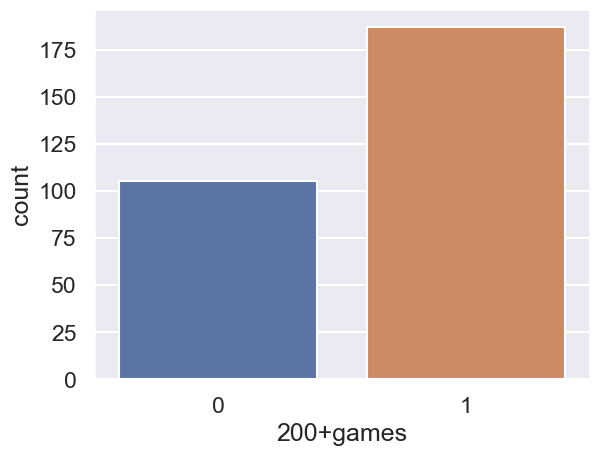

In [22]:
#plot of players with 200+ games and <200 games --> 200+ is th 1
sns.countplot(x ='200+games', data = data) 

In [23]:
#data dount, for calculating percentages 
data_count = 292

In [24]:
#displays the count and percentage of players based on games played 
less200 = data['200+games'].value_counts()[0]
plus200 = data['200+games'].value_counts()[1]
perc_less200 = round((less200/data_count)*100, 2)
perc_plus200 = round((plus200/data_count)*100, 2)
print(f'{less200} played <200 NHL games, {perc_less200}% of players') 
print(f'{plus200} played 200+ NHL games, {perc_plus200}% of players') 

105 played <200 NHL games, 35.96% of players
187 played 200+ NHL games, 64.04% of players


<AxesSubplot:xlabel='birth_month', ylabel='count'>

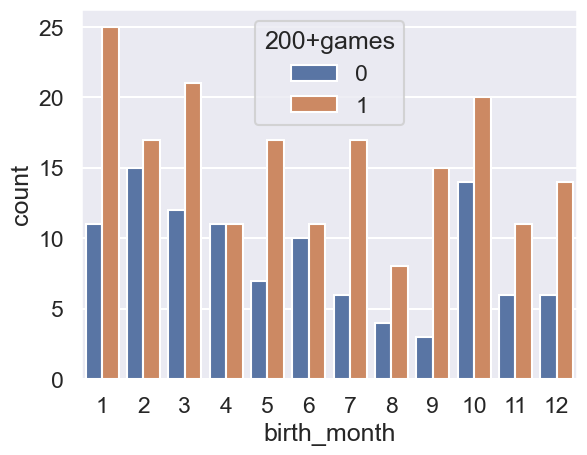

In [25]:
sns.countplot(x = data['birth_month'], hue = data['200+games'])

<AxesSubplot:xlabel='birth_month', ylabel='count'>

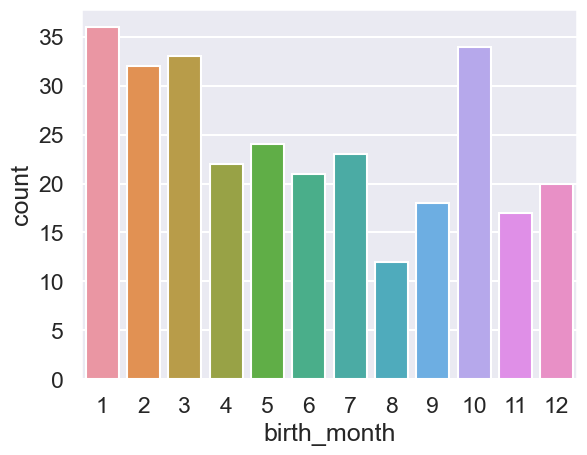

In [26]:
sns.countplot(x = data['birth_month'])

<AxesSubplot:xlabel='birth_country', ylabel='count'>

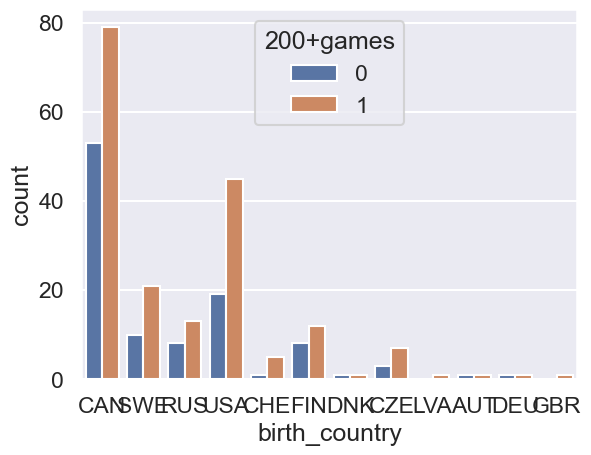

In [27]:
#birth country 
sns.countplot(x = data['birth_country'], hue = data['200+games'])

In [28]:
data['birth_country']. unique() 

array(['CAN', 'SWE', 'RUS', 'USA', 'CHE', 'FIN', 'DNK', 'CZE', 'LVA',
       'AUT', 'DEU', 'GBR'], dtype=object)

In [29]:
#games playe by country count 
data.groupby('birth_country')['200+games'].value_counts()

birth_country  200+games
AUT            0             1
               1             1
CAN            1            79
               0            53
CHE            1             5
               0             1
CZE            1             7
               0             3
DEU            0             1
               1             1
DNK            0             1
               1             1
FIN            1            12
               0             8
GBR            1             1
LVA            1             1
RUS            1            13
               0             8
SWE            1            21
               0            10
USA            1            45
               0            19
Name: 200+games, dtype: int64

<AxesSubplot:xlabel='shoots', ylabel='count'>

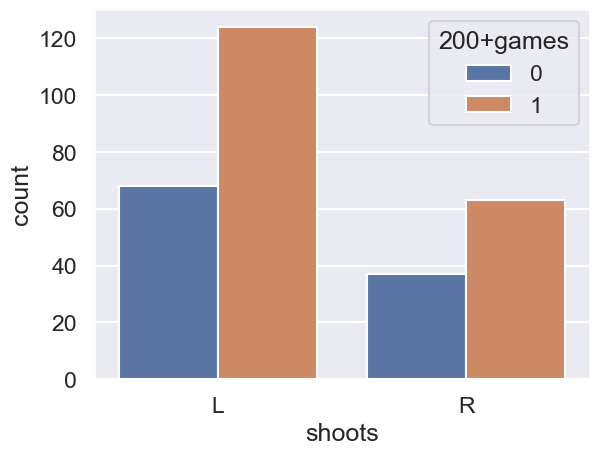

In [30]:
#shoots
sns.countplot(x = data['shoots'], hue = data['200+games'])

In [31]:
data.groupby('shoots')['200+games'].value_counts()

shoots  200+games
L       1            124
        0             68
R       1             63
        0             37
Name: 200+games, dtype: int64

<AxesSubplot:xlabel='position', ylabel='count'>

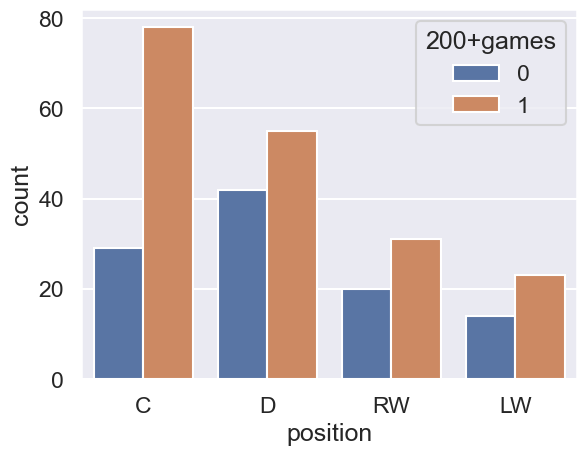

In [32]:
#position
sns.countplot(x = data['position'], hue = data['200+games'])

In [33]:
data.groupby('position')['200+games'].value_counts()

position  200+games
C         1            78
          0            29
D         1            55
          0            42
LW        1            23
          0            14
RW        1            31
          0            20
Name: 200+games, dtype: int64

<AxesSubplot:xlabel='prospect_category', ylabel='count'>

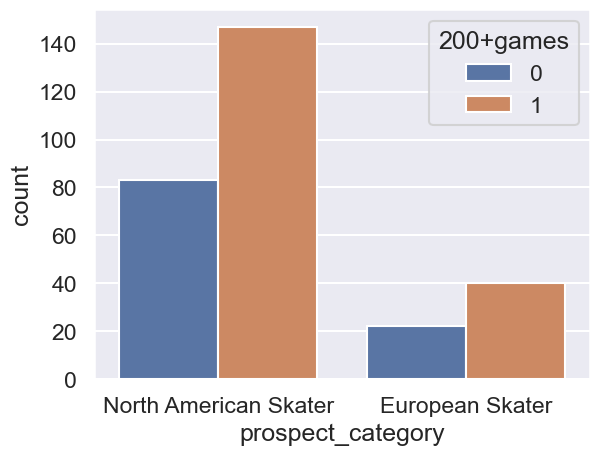

In [34]:
#prospect_category
sns.countplot(x = data['prospect_category'], hue = data['200+games'])

In [35]:
data.groupby('prospect_category')['200+games'].value_counts()

prospect_category      200+games
European Skater        1             40
                       0             22
North American Skater  1            147
                       0             83
Name: 200+games, dtype: int64

<AxesSubplot:xlabel='amateur_league', ylabel='count'>

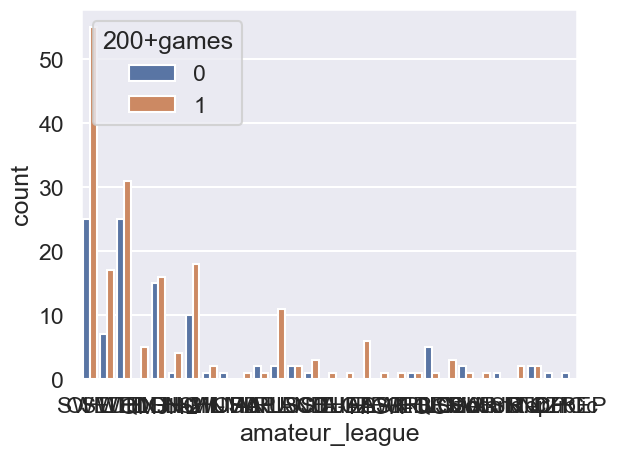

In [36]:
#amateur_league 
sns.countplot(x = data['amateur_league'], hue = data['200+games'])

In [37]:
data.groupby('amateur_league')['200+games'].value_counts()

amateur_league  200+games
AJHL            0             2
                1             1
BCHL            1             3
                0             1
BIG10           1             3
CCHA            1             1
CZECH           1             1
CZREP           0             1
Czech Republic  1             2
EJHL            1             1
FINLAND         1            11
                0             2
Finland Jr.     0             1
H-EAST          1             6
HIGH-MA         1             2
                0             1
HIGH-MN         1             4
                0             1
HIGH-QC         1             1
KHL             0             1
                1             1
NCHC            0             1
NTDP            0             2
                1             2
OHL             1            55
                0            25
QMJHL           1            16
                0            15
RUSSIA          0             2
                1             2
RUSSIA-JR.    

In [38]:
data.value_counts('amateur_league')

amateur_league
OHL               80
WHL               56
QMJHL             31
USHL              28
SWEDEN            24
FINLAND           13
SWEDEN-JR.         6
H-EAST             6
SWEDEN-2           5
HIGH-MN            5
BCHL               4
RUSSIA             4
NTDP               4
RUSSIA-JR.         3
AJHL               3
HIGH-MA            3
BIG10              3
Czech Republic     2
KHL                2
NCHC               1
HIGH-QC            1
Finland Jr.        1
EJHL               1
CZREP              1
CZECH              1
CCHA               1
SWISS              1
USDP               1
WCHA               1
dtype: int64

In [41]:
#drop data not wanted for further stats 
data_stats = data.drop(['nhl_id', 'elite_id', 'name', 'draft_year', 'draft_season', 'pick_no', 'team', 'amateur_team',
                       'nhl_games_played', 'height'], axis=1)

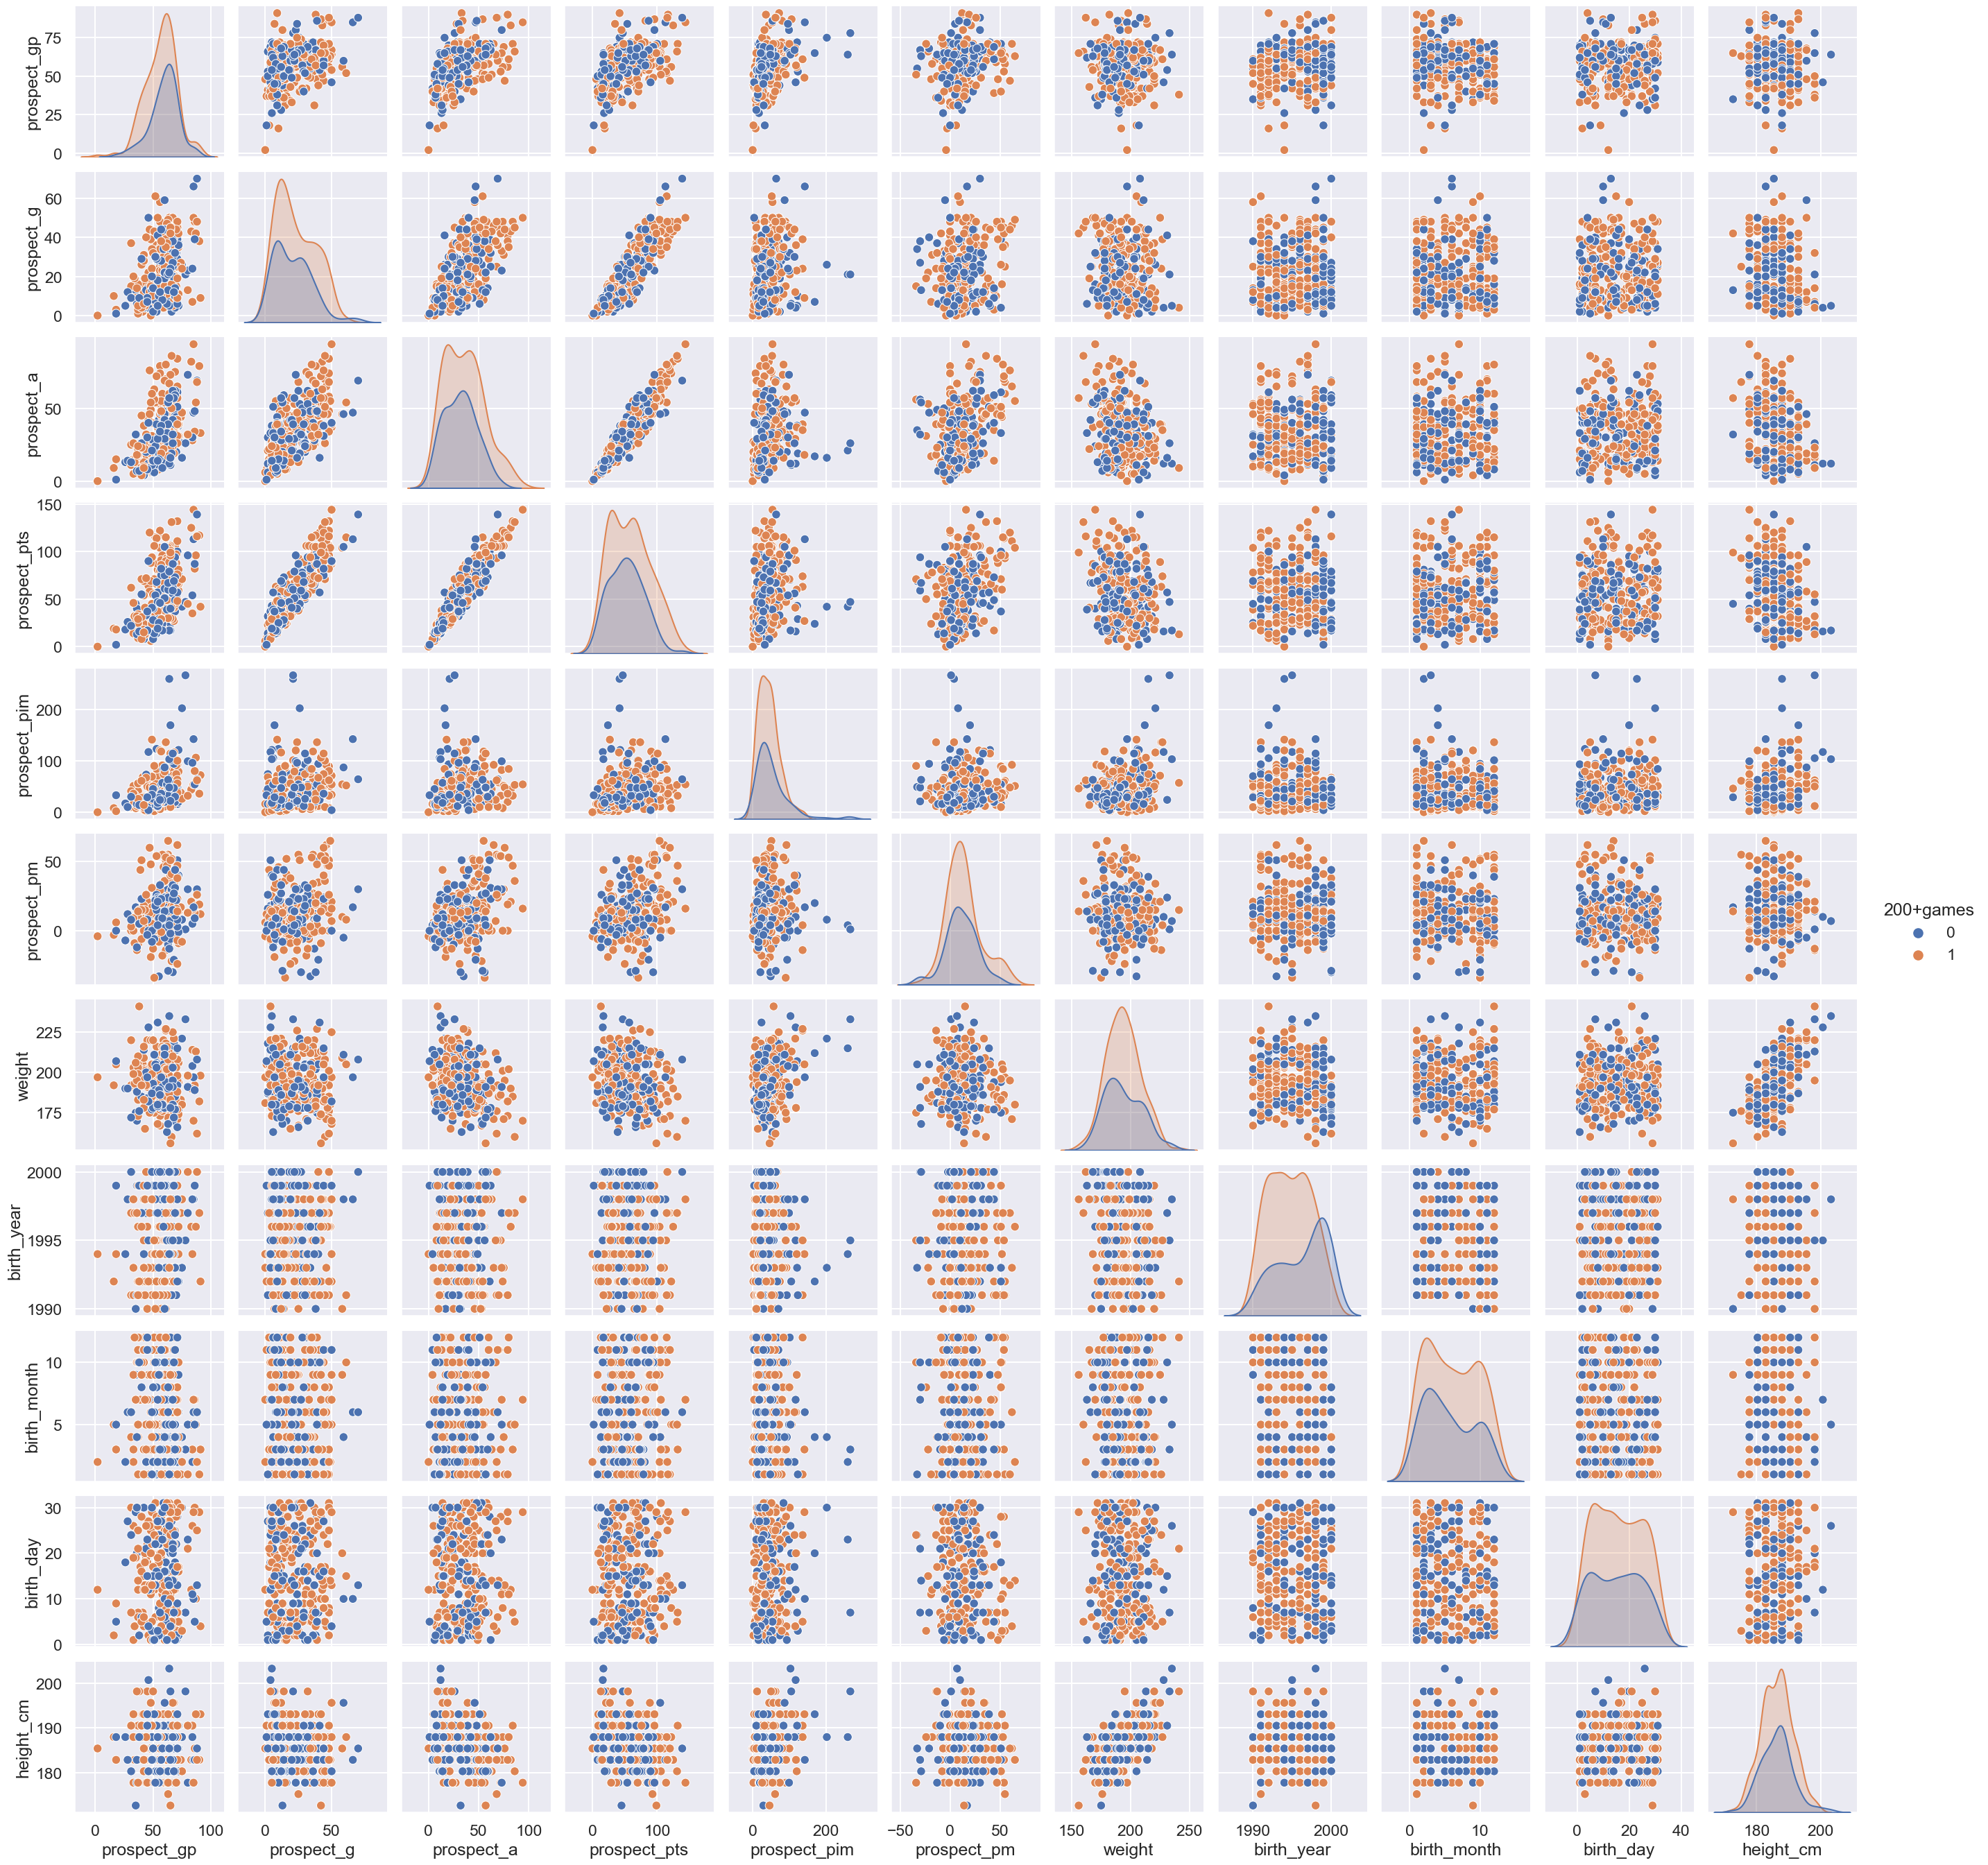

In [42]:
#pairplot 
sns.pairplot(data_stats, hue='200+games')

<AxesSubplot:>

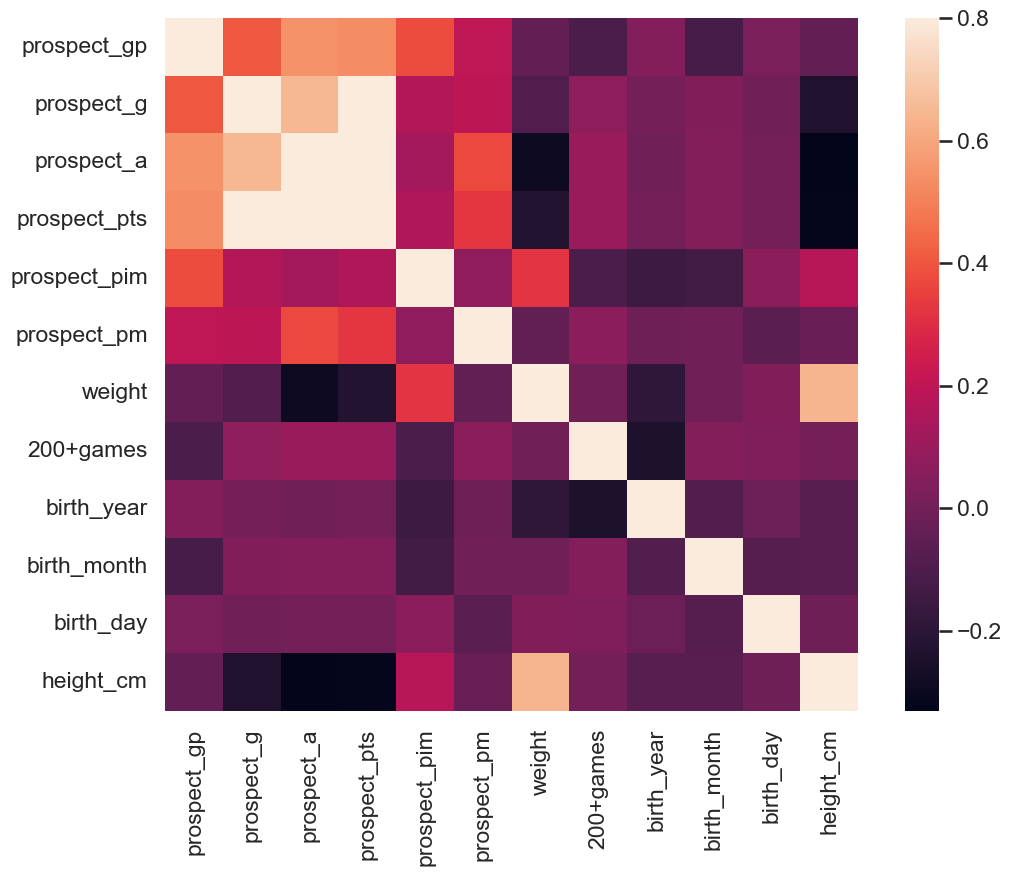

In [43]:
# correlation matrix
corrmat = data_stats.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

<AxesSubplot:xlabel='prospect_gp', ylabel='Count'>

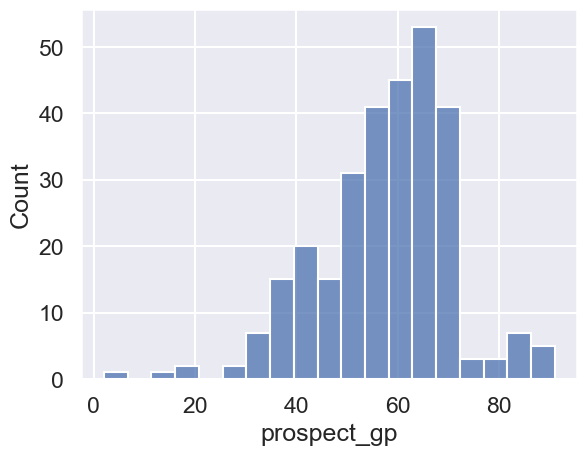

In [48]:
#histogram GP
sns.histplot(data_stats, x="prospect_gp")

<AxesSubplot:xlabel='prospect_g', ylabel='Count'>

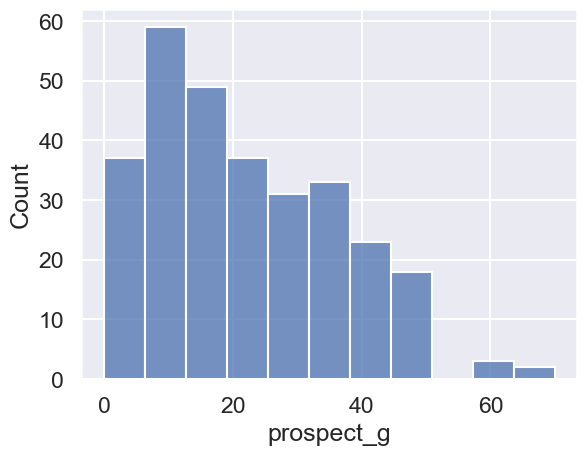

In [49]:
#histogram goals 
sns.histplot(data=data_stats, x="prospect_g")

<AxesSubplot:xlabel='prospect_a', ylabel='Count'>

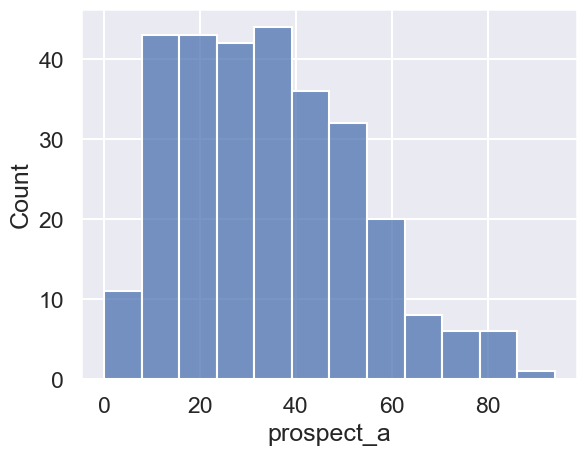

In [50]:
# histogram assists 
sns.histplot(data=data_stats, x="prospect_a")

<AxesSubplot:xlabel='prospect_pim', ylabel='Count'>

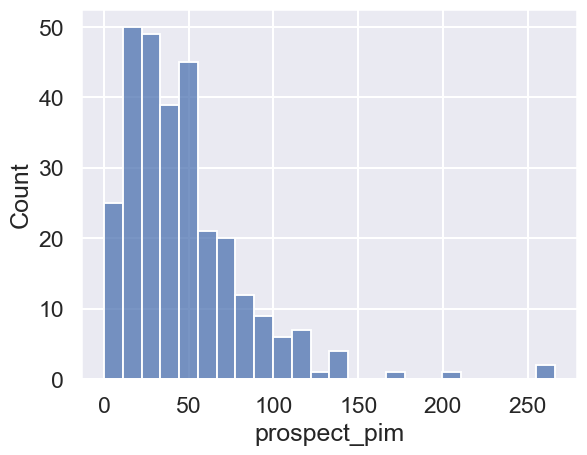

In [51]:
#histogram pim
sns.histplot(data=data_stats, x="prospect_pim")

<AxesSubplot:xlabel='prospect_pm', ylabel='Count'>

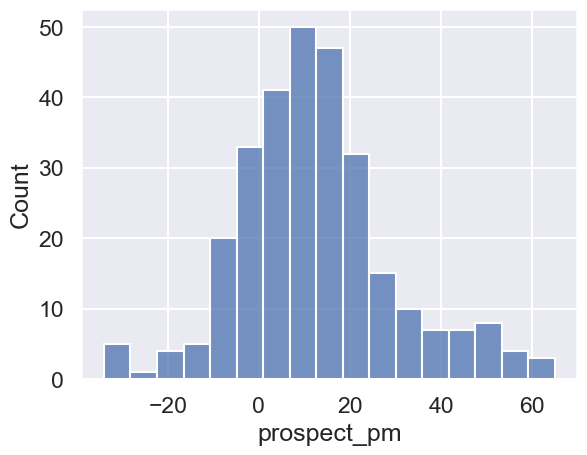

In [52]:
#histogram pm 
sns.histplot(data=data_stats, x="prospect_pm")

<AxesSubplot:xlabel='height_cm', ylabel='Count'>

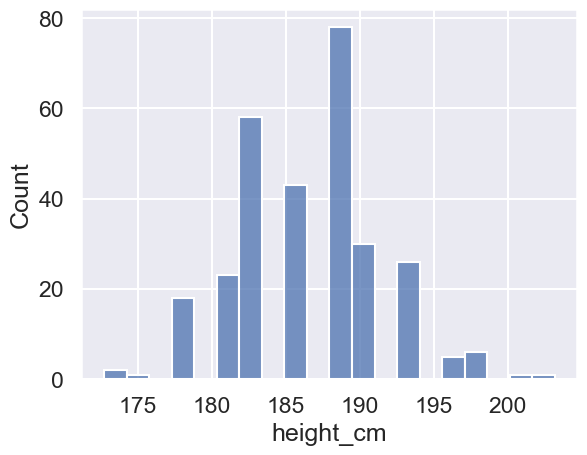

In [53]:
#histogram height cm 
sns.histplot(data=data_stats, x="height_cm")

<AxesSubplot:xlabel='weight', ylabel='Count'>

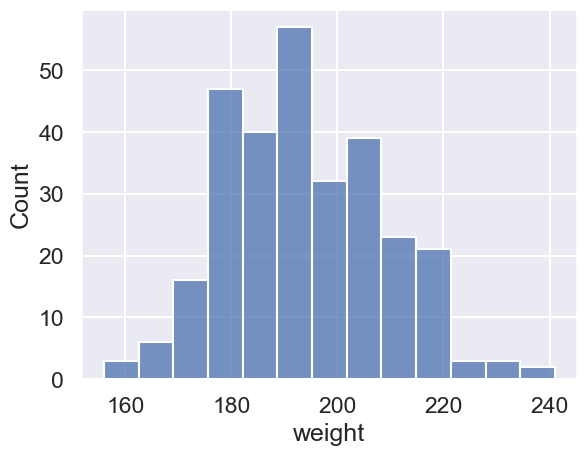

In [54]:
#histogram weight 
sns.histplot(data=data_stats, x="weight")

In [55]:
#games vs brith country 
contingency = pd.crosstab(data_stats['200+games'], data_stats['birth_country'])
contingency

birth_country  AUT  CAN  CHE  CZE  DEU  DNK  FIN  GBR  LVA  RUS  SWE  USA
200+games                                                                
0                1   53    1    3    1    1    8    0    0    8   10   19
1                1   79    5    7    1    1   12    1    1   13   21   45

In [56]:
#games vs brith country 
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}, expected = {expected}')

stat = 5.229051490141956, p = 0.9195680508762126, dof= 11, expected = [[ 0.71917808 47.46575342  2.15753425  3.59589041  0.71917808  0.71917808
   7.19178082  0.35958904  0.35958904  7.55136986 11.14726027 23.01369863]
 [ 1.28082192 84.53424658  3.84246575  6.40410959  1.28082192  1.28082192
  12.80821918  0.64041096  0.64041096 13.44863014 19.85273973 40.98630137]]


In [57]:
# games vs shoots 
contingency = pd.crosstab(data_stats['200+games'], data_stats['shoots'])
contingency

shoots       L   R
200+games         
0           68  37
1          124  63

In [58]:
#games vs shoots 
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 0.019335922247686866, p = 0.8894077409731778, dof= 1


In [59]:
# games vs position
contingency = pd.crosstab(data_stats['200+games'], data_stats['position'])
contingency

position    C   D  LW  RW
200+games                
0          29  42  14  20
1          78  55  23  31

In [60]:
#games vs position
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 6.205210085534306, p = 0.10204212976310131, dof= 3


In [61]:
# games vs birth month 
contingency = pd.crosstab(data_stats['200+games'], data_stats['birth_month'])
contingency

birth_month  1   2   3   4   5   6   7   8   9   10  11  12
200+games                                                  
0            11  15  12  11   7  10   6   4   3  14   6   6
1            25  17  21  11  17  11  17   8  15  20  11  14

In [62]:
# games vs prospect category 
contingency = pd.crosstab(data_stats['200+games'], data_stats['prospect_category'])
contingency

prospect_category  European Skater  North American Skater
200+games                                                
0                               22                     83
1                               40                    147

In [63]:
#games vs category
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 0.0, p = 1.0, dof= 1


In [64]:
# games vs amateur league 
contingency = pd.crosstab(data_stats['200+games'], data_stats['amateur_league'])
contingency

amateur_league  AJHL  BCHL  BIG10  CCHA  CZECH  CZREP  Czech Republic  EJHL  \
200+games                                                                     
0                  2     1      0     0      0      1               0     0   
1                  1     3      3     1      1      0               2     1   

amateur_league  FINLAND  Finland Jr.  ...  RUSSIA  RUSSIA-JR.  SWEDEN  \
200+games                             ...                               
0                     2            1  ...       2           2       7   
1                    11            0  ...       2           1      17   

amateur_league  SWEDEN-2  SWEDEN-JR.  SWISS  USDP  USHL  WCHA  WHL  
200+games                                                           
0                      0           5      0     0    10     1   25  
1                      5           1      1     1    18     0   31  

[2 rows x 29 columns]

In [65]:
#games vs amateur league 
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 36.96242687705957, p = 0.11969144590435983, dof= 28


In [67]:
import statsmodels.api as sm

X_logreg = data_stats[['prospect_gp', 'prospect_g', 'prospect_a', 'prospect_pim', 'prospect_pm', 'weight', 'birth_month', 'height_cm' ]]
y_logreg = data_stats[['200+games']]

log_reg = sm.Logit(y_logreg, X_logreg).fit()

Optimization terminated successfully.
         Current function value: 0.622461
         Iterations 5


In [68]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              200+games   No. Observations:                  292
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                            7
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                 0.04703
Time:                        21:40:07   Log-Likelihood:                -181.76
converged:                       True   LL-Null:                       -190.73
Covariance Type:            nonrobust   LLR p-value:                   0.01224
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
prospect_gp     -0.0371      0.013     -2.836      0.005      -0.063      -0.011
prospect_g       0.0060      0.012      0.514      0.607      -0.017       0.029
prospect_a       0.0260      0.011      2.34